# Loss function Rodrigues

$𝒟 = \{ \mathbf{x}_n, \mathbf{y}_n\}$ be a dataset of size $N$

$\mathbf{x}_n \in \mathbb{R}^D$

${\mathbf{y}}^r_n\in[0,1]^K$:   label provided for the r-th annotator in a set of R annotators

$𝒛_n$ Latent true class determined by a softmax output layer  of a DNN


$\mathbf{\sigma}\in \mathbb{R} ^Q$: DNN-based feature representation. correspond to the output of a softmax layer

$\hat{\mathbf{y}}^r_n = f_r(\sigma)\in[0,1]^{1 \times K}$

$\hat{\mathbf{y}}_n=[\hat{\mathbf{y}}^1_n,\hat{\mathbf{y}}^2_n,\dots,\hat{\mathbf{y}}^R_n]\in [0,1]^{1\times (R\times K)}$

Activation of the crowd layer for each anotator  $ \mathbf{a}^r = f_r(\sigma)$, where $f_r$ is an annotator-specific function, and the output of the crowd layer simply as the softmax of the
activations $o_c^r = e^{a_c^r}/\sum_{l=1}^{C}e^{a_l^r}$.


 $f_r(\sigma)= \mathbf{W}^r\mathbf{\sigma}$

 $\mathbf{W}^r$ is an annotator-specific matrix

 **Cost function**

 $E(\mathbf{o}^r, y^r)$
 between the expected output of the r-th annotator and its actual label $y^r$,

Then, 

if we make. $\lambda_n^r(\theta) = \mathbf{1}$ in PRI loss



$$\min_\theta \sum_n\left(\sum_r \lambda_n^r(\theta)H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\lambda_n^r(\theta)\right)\right)$$

 
we can obtain rodriguez


$$\min_\theta \sum_n\left(\sum_r (\mathbf{1})H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\mathbf{1}\right)\right)$$

In [1]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

In [2]:
# #cargar datos desde drive acceso libre
# FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
# #https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
# !unzip -o MADatasets.zip
# !dir

# Subclassing for Crowdlayer Rodriguez

In [3]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_CrowdL(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=0):
        #print('init')
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K

    
 
    def custom_CLR_loss(self, y_true, y_pred): #ytrue \in N x R,  ypred \in N x K x R  ->CrowdLayerRodriguez
        #print(y_true.shape)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1) #samples, classes 1-K, annotators
        #print(Y_true_1K.shape)    
        vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=Y_true_1K, axis = 1)
        #print(vec.shape)
        #mask = tf.equal(Y_true_1K[:,0,:], -1)
        #zer = tf.zeros_like(vec)
        #loss = tf.where(mask, x=zer, y=vec)
        #tf.print("loss", loss)
        return tf.math.reduce_sum(vec)

 
    def fit(self, X, Y):
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*4*(self.K+self.R)),activation='selu',name='h1',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        output_dense = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
                               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        output= CrowdsClassification(self.K, self.R, conn_type="MW")(output_dense) #Classes x Annotators
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss= self.custom_CLR_loss, optimizer=opt)
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split= self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose)
        #model_p  to predict labels in gridsearch  
        self.model_p = tf.keras.Model(inputs=self.model.inputs,outputs=self.model.get_layer('output').output) #se accede a capas por nombre
        #resumen y gráfica del modelo
        #print(self.model.summary())
        
        return self

    def predict2(self, X, *_):
      return  np.argmax(self.model_p.predict(X), axis=1)    
     
    def predict(self, X, *_):

       #print('predict') 
       return  self.model.predict(X) 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        #print('set_params') 
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        #print('get_params') 
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K
                }

# Crowdlayer class

In [4]:
 
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K1
from tensorflow.keras.layers import Layer
#from tensorflow.keras.engine.topology import Layer

def init_identities(shape, dtype=None):
    out = np.zeros(shape)
    for r in range(shape[2]):
        for i in range(shape[0]):
            out[i,i,r] = 1.0
    return out
    
class CrowdsClassification(Layer):


  
  #The build() method’s role is to create the layer’s variables, by calling the 
  #add_weight() method for each weight.  which is often necessary to create some of the weights.
  #we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the "kernel"): 
  #this corresponds to the size of the last dimension of the inputs. 
   
    def __init__(self, output_dim, num_annotators, conn_type="MW", **kwargs):
        self.output_dim = output_dim
        self.num_annotators = num_annotators
        self.conn_type = conn_type
        super(CrowdsClassification, self).__init__(**kwargs)



    def build(self, input_shape):
        if self.conn_type == "MW":
            # matrix of weights per annotator
      #A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors. 
      #It involves computation, defined in the call() method, and a state (weight variables). 
      #the method add_weight() offers a shortcut to create weights.

            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.output_dim, self.num_annotators),
                                            initializer=init_identities, #It is the stated initializer instance
                                            trainable=True) # trainable weights, updated via backpropagation during training
        elif self.conn_type == "VW":
            # vector of weights (one scale per class) per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(), 
                                            trainable=True)
        elif self.conn_type == "VB":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "VW+B":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True))
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "SW":
            # single weight value per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.num_annotators,1),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True)
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!")
    #At the end of the build() method (and only at the end), 
    #you must call the parent’s build() method: this tells Keras that the layer is built (it just sets self.built = True).
        super(CrowdsClassification, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
    
    #The call() method actually performs the desired operations. In this case, 
    #we compute the matrix multiplication of the inputs X and the layer’s kernel and 
    #this gives us the output of the layer.
     
 

        if self.conn_type == "MW":
            res = K1.dot(x, self.kernel)
        elif self.conn_type == "VW" or self.conn_type == "VB" or self.conn_type == "VW+B" or self.conn_type == "SW":
            out = []
            for r in range(self.num_annotators):
                if self.conn_type == "VW":
                    out.append(x * self.kernel[:,r])
                elif self.conn_type == "VB":
                    out.append(x + self.kernel[0][:,r])
                elif self.conn_type == "VW+B":
                    out.append(x * self.kernel[0][:,r] + self.kernel[1][:,r])
                elif self.conn_type == "SW":
                    out.append(x * self.kernel[r,0])
            res = tf.stack(out)
            if len(res.shape) == 3:
                res = tf.transpose(res, [1, 2, 0])
            elif len(res.shape) == 4:
                res = tf.transpose(res, [1, 2, 3, 0])
            else:
                raise Exception("Wrong number of dimensions for output")
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!") 
        
        return res
 
#The compute_output_shape() method simply returns the shape of this layer’s outputs. 
#In this case, it is the same shape as the inputs, except the last two dimensions is replaced 
#with the number of clases and # annotators in the layer.  
 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim, self.num_annotators)

# Load Data

In [5]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
 
database = 'TicTacToe' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']

data = pd.read_csv('../input/tictactoe-endgame-dataset-uci/tic-tac-toe-endgame.csv')
 

In [6]:
def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df):
    df = df.copy()
    
    # Encode label values as numbers
    df['V10'] = df['V10'].replace({'negative': 0, 'positive': 1})
    
    # One-hot encode board space columns
    df = onehot_encode(
        df,
        columns=['V' + str(i) for i in range(1, 10)]
    )
    
    # Split df into X and y
    y = df['V10'].copy()
    X = df.drop('V10', axis=1).copy()
    
    # Train-test split
   # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X, y

In [7]:
X, t = preprocess_inputs(data)

In [8]:
X = np.array(X.values)
X

array([[0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1]], dtype=uint8)

In [9]:
t = np.array(t.values)
t

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [10]:
t =t+1
t

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

# Labels Generation  

In [11]:
import random
import warnings
import numpy as np
#import climin
from functools import partial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#Defining the Sigmoid function and Softmax function
def Sigmoid(f_r):
    lam_r = 1/(1 + np.exp(-f_r))
    return lam_r

def MAjVot(Y, K):
    N,R = Y.shape
    Yhat = np.zeros((N,1))
    for n in range(N):
        votes = np.zeros((K,1))
        for r in range(R):
            for k in range(K):
                if Y[n,r] == k+1:
                    votes[k] = votes[k]+1
        Yhat[n] = np.argmax(votes) + 1
    return Yhat


def  MA_Clas_Gen(Xtrain,ytrain,R,NrP):

    N = len(ytrain)
    K = len(np.unique(ytrain))
    Kn = np.unique(ytrain)
    aux = 0
    A = np.zeros((K,1))
    for k in Kn:
        A[aux] = (ytrain == k).sum()
        aux = aux + 1
    per = np.min(A)
    if N < 25000:
        Xtrain = TSNE(n_components=1,perplexity=per/2).fit_transform(Xtrain)
    else:
        Xtrain = np.sum(Xtrain,1)
    # Xtrain = Xtrain-Xtrain.min()
    # Xtrain = Xtrain/Xtrain.max()
    #ytrain = y
    # scaler = StandardScaler()
    # scalerY = scaler.fit(y)
    # ytrain = scaler.fit_transform(y)

    
    #miny = y.min()
    #ytrain = y-miny
    #maxy = ytrain.max()
    #ytrain = ytrain/maxy
  
    # Xtrain = np.sum(Xtrain, axis=1)
    Xtrain = Xtrain - Xtrain.min()
    #print(Xtrain.min(), Xtrain.max())
    Xtrain = Xtrain/Xtrain.max()
    Xtrain = Xtrain.reshape((N,1))
    yprueba = np.ones((N,1))
    
    
    u_q = np.empty((Xtrain.shape[0],3))
    u_q[:,0,None] = 4.5*np.cos(2*np.pi*Xtrain + 1.5*np.pi) - \
                               3*np.sin(4.3*np.pi*Xtrain + 0.3*np.pi)
                    
    u_q[:,1,None] = 4.5*np.cos(1.5*np.pi*Xtrain + 0.5*np.pi) + \
                       5*np.sin(3*np.pi*Xtrain + 1.5*np.pi)
    
    u_q[:,2,None] = 1
    
    W = []
    # q=1
    Wq1 = np.array(([[0.4],[0.7],[-0.5],[0],[-0.7]]))
    W.append(Wq1)
    # q=2
    Wq2 = np.array(([[0.4],[-1.0],[-0.1],[-0.8],[1.0]]))
    W.append(Wq2)
    Wq3 = np.array(([[3.1],[-1.8],[-0.6],[-1.2],[1.0]]))
    W.append(Wq3)

    
    F_r = []
    Lam_r = []
    for r in range(R):
        f_r = np.zeros((Xtrain.shape[0], 1))
        # rho_r = np.zeros((Xtrain.shape[0], 1))
        for q in range(3):
            f_r += W[q][r].T*u_q[:,q,None]
        F_r.append(f_r)
        lam_r = Sigmoid(f_r)
        lam_r[lam_r>0.5] = 1
        lam_r[lam_r<=0.5] = 0
        Lam_r.append(lam_r)
    plt.plot(Xtrain,Lam_r[2],'rx')
    plt.show()
    seed = 0
    np.random.seed(seed)
    Ytrain = np.ones((N, R))
    for r in range(R):
        aux = ytrain.copy()
        for n in range(N):
            if Lam_r[r][n] == 0:
                labels = np.arange(1, K+1)
                a = np.where(labels==ytrain[n])
                labels = np.delete(labels, a)
                idxlabels = np.random.permutation(K-1)
                aux[n] = labels[idxlabels[0]]         
        Ytrain[:,r] = aux.flatten()
        
   # Ytrain = (Ytrain*maxy) + miny
        
    iAnn = np.zeros((N, R), dtype=int) # this indicates if the annotator r labels the nth sample.
    Nr = np.ones((R), dtype=int)*int(np.floor(N*NrP))  
    for r in range(R):
        if r < R-1:
            indexR = np.random.permutation(range(N))[:Nr[r]]
            iAnn[indexR,r] = 1
        else:
            iSimm = np.sum(iAnn, axis=1)
            idxZero = np.asarray([i for (i, val) in enumerate(iSimm) if val == 0])
            Nzeros = idxZero.shape[0]
            idx2Choose = np.arange(N)
            if Nzeros == 0:
                indexR = np.random.permutation(range(N))[:Nr[r]]
                iAnn[indexR,r] = 1
            else:
                idx2Choose = np.delete(idx2Choose, idxZero)
                N2chose = idx2Choose.shape[0]
                idxNoZero = np.random.permutation(N2chose)[:(Nr[r] - Nzeros)]
                idxTot = np.concatenate((idxZero, idx2Choose[idxNoZero]))
                iAnn[idxTot,r] = 1
    
    # Now, we verify that all the samples were labeled at least once
    Nr = (np.sum(iAnn,0))
    iSimm = np.sum(iAnn, axis=1)
    if np.asarray([i for (i, val) in enumerate(iSimm) if val == 0]).sum() == 0:
        ValueError("all the samples must be labeled at least once")

    # Finally, if iAnn=0 we assign a reference value to indicate a missing value
    Vref = -1e-20
    for r in range(R):
        Ytrain[iAnn[:,r] == 0, r] = Vref 

    return Ytrain, iAnn, Lam_r


def CrossVal(X, pp, Nk):
    N = X.shape[0]
    Ntr = int(N*pp)
    Nte = N - Ntr
    idxtr = np.zeros((Ntr,Nk))
    idxte = np.zeros((Nte,Nk))
    
    for i in range(Nk):
        index = np.random.permutation(range(N))
        idxtr[:,i] = index[:Ntr]
        idxte[:,i] = index[Ntr:]
        
    return idxtr, idxte
    
    
        


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


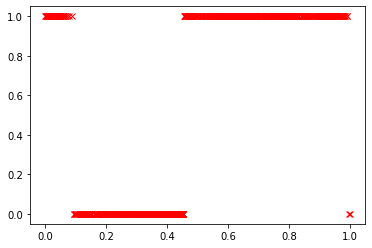

In [12]:
Y, iAnn, Lam_r = MA_Clas_Gen(X ,t, R=5, NrP=1)

In [13]:
  Y = Y - 1
  t = t - 1
  #YMA = YMA-1

annotator 1
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       332
           1       0.90      0.87      0.89       626

    accuracy                           0.86       958
   macro avg       0.84      0.85      0.84       958
weighted avg       0.86      0.86      0.86       958

annotator 2
              precision    recall  f1-score   support

           0       0.44      0.54      0.49       332
           1       0.72      0.63      0.68       626

    accuracy                           0.60       958
   macro avg       0.58      0.59      0.58       958
weighted avg       0.63      0.60      0.61       958

annotator 3
              precision    recall  f1-score   support

           0       0.46      0.61      0.53       332
           1       0.75      0.62      0.68       626

    accuracy                           0.62       958
   macro avg       0.61      0.62      0.60       958
weighted avg       0.65      0.62     

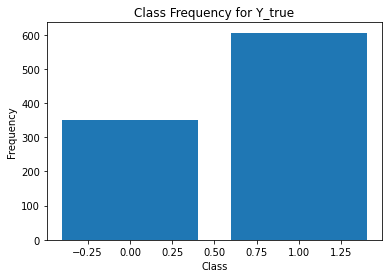

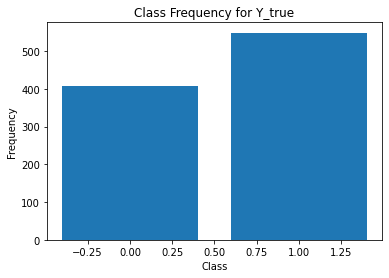

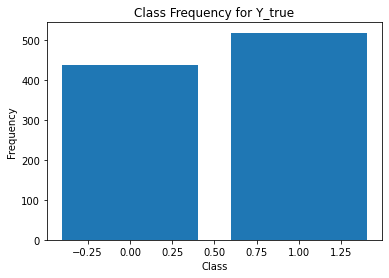

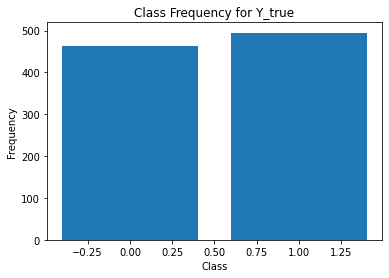

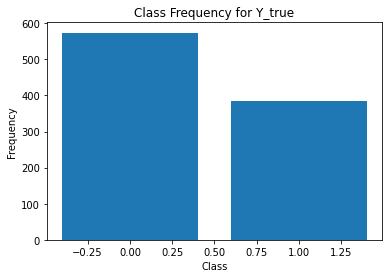

In [14]:
from sklearn.metrics import classification_report
for i in range(Y.shape[1]):
    print('annotator',i+1)
    print(classification_report(t,Y[:,i]))
    unique, counts = np.unique(Y[:,i], return_counts=True)
    plt.figure()
    plt.bar(unique, counts)
    #     unique, counts = np.unique(Y_test[5], return_counts=True)
    #     plt.bar(unique, counts)

    plt.title('Class Frequency for Y_true')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

# Split data

In [15]:
import numpy.matlib
from sklearn.model_selection import  StratifiedShuffleSplit, ShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3, random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:],Y[train_index,:], Y[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape, Y_train.shape, Y_true_train.shape)

[246 188 392 518 854 291 802 164 674 861 863 606 138   7 203 525 204 770
 343 185 591 663 774 914 270 455 900 161 261 353 396 260 210 524 752 147
 605 907 925 363 453 316 735 566 883 818 568 318 684  85 267 370 252 773
 789 683 376 660 715 565 878   5 677 571 167  41 184 200 272 814 732 893
 731 719 458 689  48 795 131 701 172 775 195 955  35 832 613 134 885 426
   4 753 478 415 381 650 399 430  50 888 882 617 328 560 280 227 274 388
 546 598  57 687 926 338 417  52 279 913 303  55 384  28 336 314 145 758
 103 114 500 706 345 811 512  54 117 619 171 462 348 221  31 444 610  36
 804 727 421 643 844 327 100 884 897 162 644 275 483 809 892 738 760  78
 463 659 306  79 177 369 310 904 351 346 229  91 170 920  90  75 372 929
 299 855 521 874 273 859 239 898 694 236 678 209 335 196 648 776  13  74
 889 249 461  59 690 456 437 151 567  11 858 769 856 285 692 733  95 797
 623 833 754 798 726 877 793 269 368 903 387 739 266 551 235 317 729 182
 374 666 107 482  97 767 538  43 908 944 781 226 15

# Apply MinMaxScaler

In [16]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
len(np.unique(Y_test))

2

In [18]:
#testing PRI as ground truth -> repeat true labels as multiple annotators
Y_true_train_K = np.matlib.repmat(Y_true_train,1, Y_train.shape[1])#testing MA as classifier
#print(X_train.shape,Y_true_train_K.shape)
# Y_train_one_hot_targets = tf.one_hot(tf.cast(Y_train , tf.int32), len(np.unique(Y_true_test)), axis = 1, dtype=tf.int32)
# Y_train_one_hot_targets.shape

# Testing the Class 

In [19]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score

l1 =0.1
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
    MA = Keras_MA_CrowdL(epochs=100,batch_size=64,R= Y_train.shape[1], K=len(np.unique(Y_true_test)), dropout=0.25, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0.3, verbose=0)


    MA.fit(X_train, Y_train)
    #MA.plot_history()
  
    #Accuracy  
    
    #estimar etiquetas modelo rodiguez 
    preds_test_num =  MA.predict2(X_test)
    
    #Accuracy
    report = classification_report(Y_true_test,preds_test_num,output_dict=True)
    ACC[i] = report['accuracy']
    
    print("Validation ACC: %.4f" % (float(report['accuracy']),))
    
    #AUC
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
   # val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test,  preds_test_num.astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    



    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), preds_test_num.squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test.squeeze(), preds_test_num.squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), preds_test_num.squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), preds_test_num.squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))




iteration: 0


2023-02-03 05:17:04.334145: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-03 05:17:04.897655: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Validation ACC: 0.6076
Validation aUc: 0.6413
Validation Balanced_ACC: 0.2826
Validation MI: 0.0410
Validation Normalized MI: 0.0614
Validation Adjusted MI: 0.0589
iteration: 1
Validation ACC: 0.6181
Validation aUc: 0.6461
Validation Balanced_ACC: 0.2922
Validation MI: 0.0428
Validation Normalized MI: 0.0637
Validation Adjusted MI: 0.0612
iteration: 2
Validation ACC: 0.6076
Validation aUc: 0.6395
Validation Balanced_ACC: 0.2790
Validation MI: 0.0396
Validation Normalized MI: 0.0592
Validation Adjusted MI: 0.0567
iteration: 3
Validation ACC: 0.6111
Validation aUc: 0.6423
Validation Balanced_ACC: 0.2846
Validation MI: 0.0411
Validation Normalized MI: 0.0614
Validation Adjusted MI: 0.0589
iteration: 4
Validation ACC: 0.6146
Validation aUc: 0.6451
Validation Balanced_ACC: 0.2902
Validation MI: 0.0426
Validation Normalized MI: 0.0636
Validation Adjusted MI: 0.0612
iteration: 5
Validation ACC: 0.6076
Validation aUc: 0.6395
Validation Balanced_ACC: 0.2790
Validation MI: 0.0396
Validation Norm

In [20]:
# from sklearn.metrics import classification_report

# l1 =0.1
# NUM_RUNS =10
# ACC = np.zeros(NUM_RUNS)
# AUC = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS): #10
#     print("iteration: " + str(i))
   
#     MA = Keras_MA_CrowdL(epochs=100,batch_size=64,R= Y_train.shape[1], K=len(np.unique(Y_true_test)), dropout=0.25, learning_rate=0.001,optimizer='Adam', 
#                 l1_param=l1,  validation_split=0.3, verbose=0)


#     MA.fit(X_train, Y_train)
#     #MA.plot_history()
  
#     #Accuracy  
    
#     #estimar etiquetas modelo rodiguez 
#     preds_test_num =  MA.predict2(X_test)
    
#     report = classification_report(Y_true_test,preds_test_num,output_dict=True)
#     ACC[i] = report['accuracy']
#     print("Validation ACC: %.4f" % (float(report['accuracy']),))
    
#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
#    # val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(Y_true_test,  preds_test_num.astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC
    
  

In [21]:
ACC

array([0.60763889, 0.61805556, 0.60763889, 0.61111111, 0.61458333,
       0.60763889, 0.62152778, 0.60069444, 0.59722222, 0.61458333])

In [22]:
AUC

array([0.64130491, 0.64609706, 0.63951105, 0.64230442, 0.64509761,
       0.63951105, 0.6524781 , 0.63213062, 0.63292503, 0.64330375])

In [23]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  61.01
Average std:  0.7100000000000001
Average AUC:  64.14999999999999
Average AUC std:  0.5700000000000001
Average Balanced Accuracy:  28.29
Average std:  1.1400000000000001
Average MI:  4.07
Average std:  0.31
Average Normalized MI:  6.08
Average std:  0.45999999999999996
Average Ajdusted MI:  5.84
Average std:  0.45999999999999996
